# Assignment 6

This assignment has weighting $3.5$.
The first question about clustering has 35%, and the second question about tiny image classification has 65%.

This is a challenging assignment, so I recommend you start early.

# Clustering for handwritten digits

Supervised learning requires labeled data, which can be expensive to acquire.
For example, a dataset with $N$ samples for classification will require manual labeling $N$ times.

One way to ameliorate this issue is to perform clustering of the raw data samples first, followed by manual inspection and labeling of only a few samples.
Recall that clustering is a form of non-supervised learning, so it does not require any class labels.

For example, say we are given a set of scanned hand-written digit images.
We can cluster them into 10 groups first, manually inspect and label a few images in each cluster, and propagate the label towards the rest of all (unlabeled) samples in each cluster.

The accuracy of such semi-automatic labeling depends on the accuracy of the clustering.
If each cluster (0 to 9) corresponds exactly to hand-written digits 0-9, we are fine.
Otherwise, we have some mis-labeled data.

The goal of this question is to exercise clustering of the scikit-learn digits dataset which has labels, so that we can verify our clustering accuracy.
The specifics are as follows.

You will be judged by the test accuracy of your code, and quality of descriptions of your method.
As a reference, a simple code I (Li-Yi) wrote can achieve about 78% accuracy. Try to beat it as much as you can.

## Training and test data split

We will split the original dataset into training and test datasets
* training for building our clusters
* testing to see if the clusters can predict future data

## Accuracy
What is your clustering accuracy (comparing cluster labels with the ground truth labels), and what are the properties of mis-clustered samples?

## Data preprocessing
Would the original features (pixels) work well, or we need further processing like scaling/standardization or dimensionality-reduction, before clustering?

## Models and hyper-parameters

Let's focus on k-means clustering, as hierarchical and density-based clustering do not provide the predict() method under scikit-learn.

What is the best test performance you can achieve with which hyper-parameters (for k-means, standard scalar, and dimensionality reduction)?

### Hint
We have learned Pipeline and GridSearchCV for cross validation and hyper-parameter tuning.

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn
%matplotlib inline

last updated: 2016-12-14 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.2
pandas 0.19.1
matplotlib 1.5.3
scipy 0.18.1
sklearn 0.18.1


In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Load data

In [3]:
import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data # data in pixels
y = digits.target # digit labels

print(X.shape)
print(y.shape)

print(np.unique(y))

(1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


## Visualize data

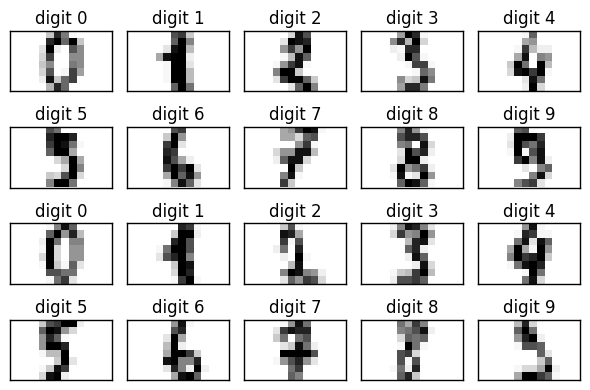

In [4]:
import matplotlib.pyplot as plt
import pylab as pl

num_rows = 4
num_cols = 5

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
ax = ax.flatten()
for index in range(num_rows*num_cols):
    img = digits.images[index]
    label = digits.target[index]
    ax[index].imshow(img, cmap='Greys', interpolation='nearest')
    ax[index].set_title('digit ' + str(label))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Data sets: training versus test

In [5]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 1257, test: 540


In [6]:
import numpy as np

# check to see if the data are well distributed among digits
for y in [y_train, y_test]:
    print(np.bincount(y))

[119 133 128 119 120 135 130 122 128 123]
[59 49 49 64 61 47 51 57 46 57]


## Answer

We first write a scoring function for clustering so that we can use for GridSearchCV.
Take a look at use_scorer under scikit learn.

In [7]:
## Note: We do not guarantee that there is a one-to-one correspondence, and therefore the toy result is different.
##       See Explanation for more information
def clustering_accuracy_score(y_true, y_pred):
    n_labels = len(list(set(y_true)))
    n_clusters = len(list(set(y_pred)))
    Pre = np.zeros((n_clusters, n_labels))
    Rec = np.zeros((n_clusters, n_labels))
    F = np.zeros((n_clusters, n_labels))
    w = np.zeros((n_clusters))
    F_i = np.zeros((n_clusters))
    P = np.zeros((n_labels))
    C = np.zeros((n_clusters))
    
    for i in range(n_clusters):
        C[i] = sum(y_pred == i)
    for j in range(n_labels):
        P[j] = sum(y_true == j)
    
    for i in range(n_clusters):
        F_i_max = 0
        for j in range(n_labels):
            if (C[i]):
                Pre[i][j] = sum(y_pred[y_true == j] == i) / C[i]
            if (P[j]):
                Rec[i][j] = sum(y_true[y_pred == i] == j) / P[j]
            if (Pre[i][j]+Rec[i][j]):
                F[i][j] = 2*Pre[i][j]*Rec[i][j]/(Pre[i][j]+Rec[i][j])    
            F_i_max = max(F_i_max, F[i][j])
        F_i[i] = F_i_max
        w[i] = sum(y_pred == i) / len(y_pred)
    return F_i.dot(w)

In [8]:
# toy case demonstrating the clustering accuracy
# this is just a reference to illustrate what this score function is trying to achieve
# feel free to design your own as long as you can justify

# ground truth class label for samples
toy_y_true = np.array([0, 0, 0, 1, 1, 2])

# clustering id for samples
toy_y_pred_true = np.array([1, 1, 1, 2, 2, 0])
toy_y_pred_bad1 = np.array([0, 0, 1, 1, 1, 2])
toy_y_pred_bad2 = np.array([2, 2, 1, 0, 0, 0])

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_true)
print('accuracy', toy_accuracy, ', should be 1')

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad1)
print('accuracy', toy_accuracy, ', should be', 5.0/6.0)

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad2)
print('accuracy', toy_accuracy, ', should be', 4.0/6.0, ', this will be explained in the following content')

accuracy 1.0 , should be 1
accuracy 0.833333333333 , should be 0.8333333333333334
accuracy 0.75 , should be 0.6666666666666666 , this will be explained in the following content


## Explanation

I adopt a modified version of F-value selection, that is, for each cluster, select the best label class with highest F-score. This accuracy calculating method supports the condition that number of clusters not equal to number of labels, which supports GridSearchCV on number of clusters.

Formula: Let $C[i]$ denotes cluster $i$ and $P[j]$ denotes label $j$. Then for each $(i, j)$, we have<br><br>
$$
\begin{align}
\text{Precision}[i][j] & = \frac{\left|C[i]\cap P[j]\right|}{|C[i]|} \\
\text{Recall}[i][j] & = \frac{\left|C[i]\cap P[j]\right|}{|P[j]|} \\
\text{F-value}[i][j] & = \frac{ 2 \times \text{Precision}[i][j] \times \text{Recall}[i][j]}{\text{Precision}[i][j] + \text{Recall}[i][j]}.
\end{align}
$$

Then for each cluster, we search the best F-value for each label, that is,
$$\text{F-value}[i] = \max\limits_{j} \text{F-value}[i][j].$$
We also store the weight $w$ for each cluster, that is,
$$w[i] = \frac{|C[i]|}{n}$$

Hence the final score is simply the dot product of $\text{F-value}$ and $w$, which is the weighted F-score.

Again, since this accuracy calculating method supports the condition that number of clusters not equal to number of labels, we __do not__ guarantee that there is a bijection between clusters and labels, therefore there are cases that some labels have no corresponding clusters, as the second toy example shows.

Build a pipeline with standard scaler, PCA, and clustering.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer
from scipy.stats import mode

pipe = Pipeline([('scl', StandardScaler()),
                 ('pca', KernelPCA()),
                 ('km', KMeans(random_state=1))])

# map cluster number to acutal label 
def cluster_mapping(y_true, y_pred):
    mapping = {}
    n_labels = len(list(set(y_true)))
    n_clusters = len(list(set(y_pred)))
    Pre = np.zeros((n_clusters, n_labels))
    Rec = np.zeros((n_clusters, n_labels))
    F = np.zeros((n_clusters, n_labels))
    P = np.zeros((n_labels))
    C = np.zeros((n_clusters))
    
    for i in range(n_clusters):
        C[i] = sum(y_pred == i)
    for j in range(n_labels):
        P[j] = sum(y_true == j)
    
    for i in range(n_clusters):
        F_i_max = 0
        F_i_max_label = 0
        for j in range(n_labels):
            if (C[i]):
                Pre[i][j] = sum(y_pred[y_true == j] == i) / C[i]
            if (P[j]):
                Rec[i][j] = sum(y_true[y_pred == i] == j) / P[j]
            if (Pre[i][j]+Rec[i][j]):
                F[i][j] = 2*Pre[i][j]*Rec[i][j]/(Pre[i][j]+Rec[i][j])    
            if (F_i_max < F[i][j]):
                F_i_max_label = j
                F_i_max = F[i][j]
        mapping[i] = F_i_max_label
    return mapping

Use GridSearchCV to tune hyper-parameters.

In [10]:
if Version(sklearn_version) < '0.18':
    from sklearn.grid_search import GridSearchCV
else:
    from sklearn.model_selection import GridSearchCV

pcs = list(range(1, 60))
kernels = ['linear', 'rbf', 'cosine']
initTypes = ['random', 'k-means++']
clusters = list(range(10, 20))
tfs = [True, False]

param_grid = [{'pca__n_components': pcs,
               'pca__kernel': kernels,
               'km__init' : initTypes,
               'km__n_clusters' : clusters,
               'scl__with_std' : tfs,
               'scl__with_mean' : tfs}]

gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring=make_scorer(clustering_accuracy_score), 
                  cv=10,
                  n_jobs=-1,
                  verbose=False)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.824823005662
{'pca__n_components': 15, 'scl__with_mean': True, 'pca__kernel': 'cosine', 'km__init': 'k-means++', 'km__n_clusters': 11, 'scl__with_std': False}


In [11]:
best_model = gs.best_estimator_

print('Test accuracy: %.3f' % clustering_accuracy_score(y_test, best_model.predict(X_test)))

Test accuracy: 0.844


Visualize mis-clustered samples, and provide your explanation.

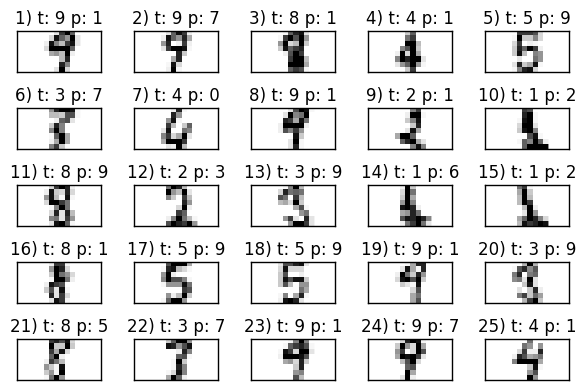

In [12]:
mapping = cluster_mapping(y_train, best_model.predict(X_train))

y_test_pred = np.array(list(map(lambda x: mapping[x], best_model.predict(X_test))))
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Explanation
Since the accuracy is 84.4%, which means more than 1 digit will be incorrectly clustered in a group of 10 digits, the error is still considered to be high (compared with using neural networks or other methods).
The mis-clustered samples, as we can observe from the picture above, are generally two kinds:
1. Hard to differentiate: e.g. No. 14, No. 21 and No, 22. It is even difficult for a human to tell which classes they should belong to.
2. Blurred to much: e.g. No. 4, No. 18 and No. 19. Those can be differentiated by a human but seems too vague to be correctly clustered. 

Furthermore, we can find that digit '5' tends to be mis-clustered to digit '9' (e.g. No. 5, No. 17 and No. 18), and digit '9' tends to be mis-clustered to digit '1' and '7' (e.g. No. 1, No. 2, No. 8, No. 19, No. 23 and No. 24). The reason may be that the distance between those digit clusters are not far, and a digit lying around the border can be easily mis-clustered. For example, when the digit is blurred/vague.<br>
Also, we can find from No. 10, No. 14, No. 15 that the digit '1' in the dataset are sometimes twisted, tilted or blurred. It's even hard for a human to tell whether it is digit '1' or not. From the examples, we can see that they tend to be clustered as digit '6' or '2' with respect to their shape and level of clarity.

# Tiny image classification

We will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) for image object recognition.
The dataset consists of 50000 training samples and 10000 test samples in 10 different classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck; see the link above for more information).
The goal is to maximize the accuracy of your classifier on the test dataset after being optimized via the training dataset.

You can use any learning models (supervised or unsupervised) or optimization methods (e.g. search methods for hyper-parameters).
The only requirement is that your code can run inside an ipynb file, as usual.
Please provide a description of your method, in addition to the code.
Your answer will be evaluated not only on the test accuracy but also on the creativity of your methodology and the quality of your explanation/description.

# Description

## 1. Introduction

### 1.1. High-level approach
I adopted a Wide Residual Network with 28 convolutional layers and 10x width. As stated Zagoruyko et al's paper <sup>[1](#myfootnote1)</sup>, a 96.11% testing accuracy can be obtained.

### 1.2. Reason
Without cifar-10 data size-augmentation<sup>[2](#myfootnote2)</sup>, one of the best test results - a 93.57% testing accuracy is reported<sup>[3](#myfootnote3)</sup> with the famous deep residual netwook<sup>[4](#myfootnote4)</sup>. Since the desired testing accuracy is high, I decided to start from resnet. However, inspired by Zagoruyko et al, I choose to use a modified version of resent - the Wide Residual Network. <br><br>
Wide resent basically increases the channel of each convolutional layer while decreasing the depth of the network. With result data from their work, a structure of 28 convolution layers and 10x width with dropout achieves the best result - 96.11% accuracy.<br><br>
When training my network, however, I only found the result of their early version's paper<sup>[5](#myfootnote5)</sup>, which is training without dropout layer achieves better accuracy (which is also modified from 95.61% to 96.00% in the lastest version). Moreover, due to assignment time constraint, I simply use the default adadelta optimizer instead of [sgd + selected learning rate] in the first 100 itertaions, which may accounts for my less accurate result. After finetuning, in the end, I only get a 94.14% accuarcy, which is still higher than the original resnet.


## 2. Method

### 2.1 Data Preprocessing

Using `keras.preprocessing.image.ImageDataGenerator`, the data preprocessing scheme I use is
1. `featurewise_center`: Set feature-wise input mean to 0 over the dataset
2. `featurewise_std_normalization`: Divide inputs by feature-wise std of the dataset
3. `rotation_range`: 10$^{\circ}$ range for random rotations
4. `width_shift_range`: 15.625% random horizontal shifts
5. `height_shift_range`: 15.625% random vertical shifts
6. `horizontal_flip`: Randomly flip inputs horizontally

Since `vertical_flip` looks unrealistic for a real-world picture, I did not use it. Also, `zca_whitening` may results in loss of image info, and other methods may more or less lead to problems in training.<br>

Moreover, I did not adopte cifar-10 data size-augmentation<sup>[2](#myfootnote2)</sup>, which requires structural changes to my network, which may results in more time cost in training and finetuning. As the paper suggests, the test accuracy should increase compared with non-size-augmentated data.

### 2.2 Model

Since we use 28 convolutional layers, by structure of wide resnet, the layer blocks are:
1. A initial block with 1 convolutional layers
2. 4 conv1 block with 160 channels. All blocks contains 2 convolutional layers. The first block contains one additional residual convolutional layer. In total 3+2+2+2=9 convolutional layers. Each block ends with a residual merge.
3. 4 conv2 block with 320 channels. All blocks contains 2 convolutional layers. The first block contains one additional residual convolutional layer. In total 3+2+2+2=9 convolutional layers. Each block ends with a residual merge.
4. 4 conv3 block with 640 channels. All blocks contains 2 convolutional layers. The first block contains one additional residual convolutional layer. In total 3+2+2+2=9 convolutional layers. Each block ends with a residual merge.

All convolutional layers are followed by a batch normalization layer and a relu layer.<br>
After all layer blocks, we use average pooling to 8-by-8, followed by a flatten layer, and finalliy a fully connected layer (with softmax) of 10 outputs, which corresponds to each class.

### 2.3 Hyper-parameter

As discussed in 1.2, the most important hyper-parameter of wide resnet, also as Zagoruyko et al discribed, is N (the number of layers), K (the width of the convolutional channel), and dropout ratio. I adopted the best result from version 1 of their work, that is, N = 28, K = 10 (times original resnet), dropout ratio = 0. However, as their version 2 points out, this model with dropout can achieve a better result. Since the difference is just 0.11%, we can see that dropout may not influence much in wide resnet.

### 2.4 Detailed Model

You may view the detailed model in the following code output.

## 3. Result

| Network | Accuracy |
|------------------------------------------|--------|
| Kaiming He et al Resent | 93.57% |
| My WRN-28-10 w/o dropout (Adadelta only) | 93.69% |
| My WRN-28-10 w/o dropout (Fine-tuned) | 94.14% |
| Zagoruyko et al WRN-28-10 v1 w/ dropout | 95.61% |
| Zagoruyko et al WRN-28-10 v1 w/o dropout | 95.83% |
| Zagoruyko et al WRN-28-10 v2 w/o dropout | 96.00% |
| Zagoruyko et al WRN-28-10 v2 w/ dropout | 96.11% |

With adadelta optimizer only, my training accuracy finally becomes 100%, which denotes an over-fitting and thus making the testing accuracy fail to improve. With SGD fine-tuning on the model, the testing accuracy increases around 0.45%. However, my model fail to achieve a testing accuracy above 95% as the papaer suggestes. See 4.2 Limitations for more analysis.<br>

Note that the code I provided below simply uses the fine-tuned result of my network, and the training process is just for showing the result. They are not the original processes.

## 4. Conclusion

### 4.1 Traning Conclusion
1. Wide Residual Network achieves better result than the original Residual Network.
2. Optimizer choice, fine-tuning and data augmentation are curtial for improving the testing rate.
3. Ideas that worked several years ago may not work nowadays, ideas that work on a specific model may not work on another model (e.g. importance of dropout, improving the depth always work on resnet)
4. The importance of keeping track of the latest news and models on machine learning. 

### 4.2 Limitations
1. Optimizer, Regulation and Over-fitting:
With more time provided, I would try to use [different optimizer (adagrad, RMSprop, adam, sgd+specific training rate) + different Regulation (l1, l2)] instead of using adadelta only. This may account for the 1.5% accuracy below the paper's result. 
2. Dropout:
As the second version of the paper suggested, with dropout the testing accuracy improved 0.11%. However, this should not be the major contraint of the result.
3. Fine-tuning:
I only ran 50 iterations of fine-tuning based on the training rate I set. The peak testing accuracy I obtained is 94.49% but was not saved during fine-tuning.
4. Data Augmentation:
Cifar-10 data size-augmentation<sup>[2](#myfootnote2)</sup> is proved to be useful to improve the testing rate, which I did not try during my training.
5. FCN:
Fully Convolutional Network<sup>[6](#myfootnote6)</sup> is proved to be useful to improve the testing rate. Also, R-FCN<sup>[7](#myfootnote7)</sup> provides a nice implimentation of Fully Convolutional Resnet. Maybe a wide, fully convolved residual network can provides a better result.
6. Use of GPU:
AWS refused to provide me with a GPU instance since I am a new user. I trained my network on my Nvidia GeForce GTX 980M, which takes 7 days to run 100 iterations. This heavily limited adjustments to my model.

## 5. References
<a name="myfootnote1">1</a>: [Zagoruyko, Sergey, and Nikos Komodakis. "Wide Residual Networks." arXiv preprint arXiv:1605.07146v2 (2016).](https://arxiv.org/pdf/1605.07146v2.pdf)<br>
<a name="myfootnote2">2</a>: [Graham, Benjamin. "Fractional max-pooling." arXiv preprint arXiv:1412.6071 (2015).](https://arxiv.org/pdf/1412.6071v4.pdf)<br>
<a name="myfootnote3">3</a>: [Benenson. What is the class of this image ?" rodrigob@github](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)<br>
<a name="myfootnote4">4</a>: [He, Kaiming, et al. "Deep residual learning for image recognition." arXiv preprint arXiv:1512.03385 (2015).](https://arxiv.org/pdf/1512.03385v1.pdf)<br>
<a name="myfootnote5">5</a>: [Zagoruyko, Sergey, and Nikos Komodakis. "Wide Residual Networks." arXiv preprint arXiv:1605.07146v1 (2016).](https://arxiv.org/pdf/1605.07146v1.pdf)<br>
<a name="myfootnote6">6</a>: [Long, Jonathan, Evan Shelhamer, and Trevor Darrell. "Fully convolutional networks for semantic segmentation." IEEE Conference on CVPR. 2015.](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)<br>
<a name="myfootnote7">7</a>: [Dai, Jifeng, et al. "R-FCN: Object Detection via Region-based Fully Convolutional Networks." arXiv preprint arXiv:1605.06409 (2016).](https://arxiv.org/pdf/1605.06409.pdf)<br>
All codes referenced have been specified in their context.

In [1]:
# Functions to build a user-defined wide resnet for cifa-10
# Author: Somshubra Majumdar https://github.com/titu1994/Wide-Residual-Networks
# Modified By: Gao Chang, HKU

from keras.models import Model
from keras.layers import Input, merge, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

def initial_conv(input):
    x = Convolution2D(16, 3, 3, border_mode='same')(input)

    channel_axis = 1 if K.image_dim_ordering() == "th" else -1

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    return x

def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_dim_ordering() == "th" else -1

    # Check if input number of filters is same as 16 * k, else create convolution2d for this input
    if K.image_dim_ordering() == "th":
        if init._keras_shape[1] != 16 * k:
            init = Convolution2D(16 * k, 1, 1, activation='linear', border_mode='same')(init)
    else:
        if init._keras_shape[-1] != 16 * k:
            init = Convolution2D(16 * k, 1, 1, activation='linear', border_mode='same')(init)

    x = Convolution2D(16 * k, 3, 3, border_mode='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = Convolution2D(16 * k, 3, 3, border_mode='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = merge([init, x], mode='sum')
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_dim_ordering() == "th" else -1

    # Check if input number of filters is same as 32 * k, else create convolution2d for this input
    if K.image_dim_ordering() == "th":
        if init._keras_shape[1] != 32 * k:
            init = Convolution2D(32 * k, 1, 1, activation='linear', border_mode='same')(init)
    else:
        if init._keras_shape[-1] != 32 * k:
            init = Convolution2D(32 * k, 1, 1, activation='linear', border_mode='same')(init)

    x = Convolution2D(32 * k, 3, 3, border_mode='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = Convolution2D(32 * k, 3, 3, border_mode='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = merge([init, x], mode='sum')
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_dim_ordering() == "th" else -1

    # Check if input number of filters is same as 64 * k, else create convolution2d for this input
    if K.image_dim_ordering() == "th":
        if init._keras_shape[1] != 64 * k:
            init = Convolution2D(64 * k, 1, 1, activation='linear', border_mode='same')(init)
    else:
        if init._keras_shape[-1] != 64 * k:
            init = Convolution2D(64 * k, 1, 1, activation='linear', border_mode='same')(init)

    x = Convolution2D(64 * k, 3, 3, border_mode='same')(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = Convolution2D(64 * k, 3, 3, border_mode='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    m = merge([init, x], mode='sum')
    return m

def WRN(nb_classes, N, k, dropout):
    """
    Creates a Wide Residual Network with specified parameters
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    """
    init = Input(shape=(3, 32, 32))
    
    x = initial_conv(init)

    for i in range(N):
        x = conv1_block(x, k, dropout)
        
    x = MaxPooling2D((2,2))(x)

    for i in range(N):
        x = conv2_block(x, k, dropout)

    x = MaxPooling2D((2,2))(x)

    for i in range(N):
        x = conv3_block(x, k, dropout)

    x = AveragePooling2D((8,8))(x)
    x = Flatten()(x)
    x = Dense(nb_classes, activation='softmax')(x)

    model = Model(init, x)
    return model

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is disabled, cuDNN 5005)


In [2]:
import numpy as np
import sklearn.metrics as metrics
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input
from keras.optimizers import SGD
import keras.callbacks as callbacks
import keras.utils.np_utils as kutils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

batch_size = 64
nb_epoch = 5

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_train /= 255.0
X_test = X_test.astype('float32')
X_test /= 255.0

y_train = kutils.to_categorical(y_train)
y_test = kutils.to_categorical(y_test)

generator = ImageDataGenerator(featurewise_center=True,
                               featurewise_std_normalization=True,
                               rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,
                               horizontal_flip=True)

generator.fit(X_train, seed=0, augment=True)

test_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True)

test_generator.fit(X_test, seed=0, augment=True)

model = WRN(nb_classes=10, N=4, k=10, dropout=0.0)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 32, 32)    448         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 16, 32, 32)    32          convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 32, 32)    0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [3]:
print ("Start Training:")

sgd = SGD(lr = 0.001, decay = 0.1, momentum = 0.9, nesterov = True)

model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])

# model.load_weights("WRN-28-10.h5")

model.fit_generator(generator.flow(X_train, y_train, batch_size=batch_size),
                    samples_per_epoch=len(X_train),
                    nb_epoch=nb_epoch,
#                     callbacks=[callbacks.ModelCheckpoint("WRN-28-10-Best.h5", monitor="val_acc", save_best_only=True)],
                    validation_data=test_generator.flow(X_test, y_test, batch_size=batch_size),
                    nb_val_samples=X_test.shape[0],
                    verbose = True)

Start Training:
Epoch 1/5
50000/50000 [==============================] - 5208s - loss: 3.1280e-04 - acc: 1.0000 - val_loss: 0.3443 - val_acc: 0.9409
Epoch 2/5
50000/50000 [==============================] - 5009s - loss: 0.0023 - acc: 0.9992 - val_loss: 0.3471 - val_acc: 0.9406
Epoch 3/5
50000/50000 [==============================] - 5013s - loss: 0.0080 - acc: 0.9972 - val_loss: 0.3442 - val_acc: 0.9408
Epoch 4/5
50000/50000 [==============================] - 5013s - loss: 0.0086 - acc: 0.9970 - val_loss: 0.3287 - val_acc: 0.9444
Epoch 5/5
50000/50000 [==============================] - 5002s - loss: 0.0080 - acc: 0.9972 - val_loss: 0.3495 - val_acc: 0.9393


In [6]:
print ("Start Testing:")

# model.load_weights("WRN-28-10.h5")
results = model.evaluate_generator(test_generator.flow(X_test, y_test, batch_size=batch_size), X_test.shape[0])

print ("Results:")
print ("Test loss: {0}".format(results[0]))
print ("Test accuracy: {0}".format(results[1]))

Start Testing:
Results:
Test loss: 0.3487206139005721
Test accuracy: 0.9414
